In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# import libraries
import numpy as np
import sys
import psi4
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt
import json
import os

# import libraries
import numpy as np
import sys
import psi4
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt
import json
import os 


$$ |\psi_n^{(k)}\rangle = \sum_{m \neq n} \frac{\langle \psi_m^{(0)} | \hat{H}' | \psi_n^{(k-1)} \rangle}{E_n^{(0)} - E_m^{(0)}} |\psi_m^{(0)} \rangle $$
$$ E_n^{(k)} = \langle \psi_n^{(0)} | \hat{H}' | \psi_n^{(k-1)} \rangle $$

Note:

$$ \hat{U}_{CS} \hat{b} \hat{U}^{\dagger}_{CS} = \hat{b} - z $$

$$ \hat{U}_{CS} \hat{b}^{\dagger} \hat{U}^{\dagger}_{CS} = \hat{b}^{\dagger} - z $$

where 

$$ z = -\frac{\langle \hat{d} \rangle}{\sqrt{2 \omega}} $$


In [2]:



class PT_arbitrary:

    def __init__(self, energies, dipoles):
        self.E_array = energies
        self.dipoles = dipoles




    def create_annihilation_operator(self,N):
        """
        Creates the matrix representation of the annihilation operator (b) for a harmonic oscillator
        in a Hilbert space with N levels.
        
        Parameters:
        N (int): Number of levels.
        
        Returns:
        np.ndarray: The matrix representation of the annihilation operator.
        """
        b = np.zeros((N, N))
        
        for j in range(1, N):
            b[j-1, j] = np.sqrt(j)
        
        return b

    def create_creation_operator(self,N):
        """
        Creates the matrix representation of the creation operator (b†) for a harmonic oscillator
        in a Hilbert space with N levels.
        
        Parameters:
        N (int): Number of levels.
        
        Returns:
        np.ndarray: The matrix representation of the creation operator.
        """
        b_dagger = np.zeros((N, N))
        
        for j in range(1, N):
            b_dagger[j, j-1] = np.sqrt(j)
        
        return b_dagger



    def create_number_operator(self,N):
        """
        Creates the matrix representation of the number operator (n) = b† * b.
        
        Parameters:
        N (int): Number of levels.
        
        Returns:
        np.ndarray: The matrix representation of the number operator.
        """
        b = self.create_annihilation_operator(N)
        b_dagger = self.create_creation_operator(N)
        
        # The number operator is n = b† * b
        n = np.dot(b_dagger, b)
        
        return n



    def build_d_array(
        self,
        n_el,
        lambda_vector,
        mu_array,
        coherent_state=False,
        coherent_state_pos = None,
        coherent_state_val = None
        ):
        """
        method to compute the array d = \lambda \cdot \mu if coherent_state==False
        or d = \lambda \cdot (\mu - <\mu>) if coherent_state == True
        and store to attribute self.d_array
        """

        if coherent_state == False:
            d_array = np.einsum(
                "k,ijk->ij", lambda_vector, mu_array[:n_el, :n_el, :]
            )

        else:
            _I = np.eye(n_el)
            d_array = np.einsum(
                "k,ijk->ij", lambda_vector, mu_array[:n_el, :n_el, :]
            )

            if coherent_state_val == None and coherent_state_pos == None:
                _d_exp = d_array[0, 0]
            elif coherent_state_val == None and coherent_state_pos != None:
                _d_exp = d_array[coherent_state_pos, coherent_state_pos]
            else:
                _d_exp = coherent_state_val

            d_array = d_array - _I * _d_exp

        return d_array

    def compute_energy_corrections(self, order, n_el, n_ph, omega, lambda_vector,  coherent_state = False, coherent_state_val= None, coherent_state_pos = None, ):

        n_max = n_el * n_ph
        n = 0

        # Identity matrices for each subsystem
        I_matter = np.eye(n_el)
        I_photon = np.eye(n_ph)

        # Build dipole moment matrix _d
        d_array = self.build_d_array(
                n_el, lambda_vector, self.dipoles, coherent_state, coherent_state_pos, coherent_state_val
            )
        _d = np.copy(d_array)


        # Create bosonic subspace operators
        b = self.create_annihilation_operator(n_ph)
        b_dagger = self.create_creation_operator(n_ph)
        N = self.create_number_operator(n_ph)


        # Electronic energy contribution (diagonal in matter space, identity in photon space)
        E_matter = np.diag(self.E_array[:n_el])
        E = np.kron(I_photon, E_matter)

        # Photon energy contribution (diagonal in photon space, identity in matter space)
        Cav_photon = omega * N
        Cav = np.kron( Cav_photon, I_matter)

        #Bilinear light-matter coupling term

        BLC_matter = _d
        BLC_photon = (b_dagger + b)

        BLC = - np.sqrt(omega / 2)  *  np.kron( BLC_photon, I_matter) @ np.kron(I_photon, BLC_matter)


        # Dipole -energy term
        DSE_matter = 1 / 2 * _d @ _d

        DSE = np.kron( I_photon, DSE_matter)

        # Total Hamiltonian
        H0 = E + Cav  
        V= BLC +DSE



        # Diagonalize the unperturbed Hamiltonian
        E0, psi0 = np.linalg.eigh(H0)


        #psi0[:, 0] is firt wavefunction
        print(psi0.shape)

        # Initialize corrections to energy and wavefunction
        energy_corrections = np.zeros(( order+1))
        blc_corrections = np.zeros(( order+1))
        dse_corrections = np.zeros(( order+1))
        wavefunction_corrections = np.zeros((n_max, order+1))



        # Set unperturbed energies and wavefunctions
        energy_corrections[ 0] = E0[n]
        wavefunction_corrections[ :, 0] = psi0[:, n]


        n_0 = 0


        for k in range(1, order + 1):
            
            if k == 1:
                #first order energy correction
                energy_corrections[1] = np.dot(psi0[:, n].T, np.dot(V, psi0[:,n]))
                blc_corrections[1] = np.dot(psi0[:, n].T, np.dot(BLC, psi0[:,n]))
                dse_corrections[1] = np.dot(psi0[:, n].T, np.dot(DSE, psi0[:,n]))

                print(F' 1st Order Energy Correction {energy_corrections[1]}')
                print(F' 1st Order BLC Correction    {blc_corrections[1]}')
                print(F' 1st Order DSE Correction    {dse_corrections[1]}')


                coeff_m = 0
                for m in range(0, n_max):
                    coeff_m = 0
                    if m!= n:


                        coeff_m -=   np.dot(psi0[:, m].T, np.dot(V, psi0[:,n]))

                        for l in range(1, k+1):
                            #goes from l to k-1
                            coeff_m += energy_corrections[l] * np.dot(psi0[:, m].T, wavefunction_corrections[:, k-l])

                        coeff_m = coeff_m/np.abs(E0[m] - E0[n])

                        wavefunction_corrections[:, k ] += (coeff_m * psi0[:,m])


            if k!=1:  
                for m in range(0, n_max):
                    coeff_m = 0
                    if m!= n:
                        coeff_m -=  np.dot(psi0[:,m].T, np.dot(V, wavefunction_corrections[:, k-1]))
                        for l in range(1, k+1):
                            #goes from l to k-1
                            coeff_m += energy_corrections[l] * np.dot(psi0[:, m].T, wavefunction_corrections[:, k-l])

                        coeff_m = coeff_m/np.abs(E0[m] - E0[n])
                        # print("coeff_ m for state ", m , ": ", coeff_m)

                        wavefunction_corrections[:, k ] += (coeff_m * psi0[:,m])



            if k!= 1:
                energy_correction =  np.dot(psi0[:,n].T, np.dot(V, wavefunction_corrections[:, k-1]))
                blc_correction =  np.dot(psi0[:,n].T, np.dot(BLC, wavefunction_corrections[:, k-1]))
                dse_correction =  np.dot(psi0[:,n].T, np.dot(DSE, wavefunction_corrections[:, k-1]))
                
                for j in range(0, k):
                    if j != k:
                        #print("energy correction for ", j ," : " ,energy_correction)
                        energy_correction -=  energy_corrections[j]  * np.dot(psi0[:,n].T,  wavefunction_corrections[:, k-j])
                        blc_correction -=  blc_corrections[j]  * np.dot(psi0[:,n].T,  wavefunction_corrections[:, k-j])
                        dse_correction -=  dse_corrections[j]  * np.dot(psi0[:,n].T,  wavefunction_corrections[:, k-j])

                energy_corrections[ k] = energy_correction
                blc_corrections[ k] = blc_correction
                dse_corrections[ k] = dse_correction


        #print("energy_corrections: " , energy_corrections)
        return energy_corrections, blc_corrections, dse_corrections

                    

    def PQED_Hamiltonian(self, n_el, n_ph, omega, lambda_vector,  coherent_state = False, coherent_state_val= None, coherent_state_pos = None,  ):
        """
        Build the PF Hamiltonian for a system with n_el electronic states and n_ph photon states.
        """

        # Identity matrices for each subsystem
        I_matter = np.eye(n_el)
        I_photon = np.eye(n_ph)

        # Build dipole moment matrix _d
        d_array = self.build_d_array(
                n_el, lambda_vector, self.dipoles, coherent_state, coherent_state_pos, coherent_state_val
            )
        _d = np.copy(d_array)


        # Create bosonic subspace operators
        b = self.create_annihilation_operator(n_ph)
        b_dagger = self.create_creation_operator(n_ph)
        N = self.create_number_operator(n_ph)


        # Electronic energy contribution (diagonal in matter space, identity in photon space)
        E_matter = np.diag(self.E_array[:n_el])
        E = np.kron(I_photon, E_matter)

        # Photon energy contribution (diagonal in photon space, identity in matter space)
        Cav_photon = omega * N
        Cav = np.kron( Cav_photon, I_matter)

        #Bilinear light-matter coupling term

        BLC_matter = _d
        BLC_photon = (b_dagger + b)

        BLC = - np.sqrt(omega / 2)  *  np.kron( BLC_photon, I_matter) @ np.kron(I_photon, BLC_matter)


        # Dipole -energy term
        DSE_matter = 1 / 2 * _d @ _d

        DSE = np.kron( I_photon, DSE_matter)

        # Total Hamiltonian
        H = E + Cav  + BLC + DSE


        self.PCQED_MU = np.kron(I_photon, _d)


        # Return eigenvalues of the Hamiltonian
        eigenvalues, eigenvectors = np.linalg.eigh(H)
        return eigenvalues, eigenvectors, H



In [3]:
# read data from .npy files for formaldehyde casci(8,8) calculations
#Drive link for .npy files of LiH

# https://drive.google.com/drive/folders/1NQvqQ4KiXTmZZ3OjCM5nA2dqIs5ete9X?usp=sharing

# !!! Change this to the correct path on your computer!
#npy_folder = "/Users/proden/Code/POLARITONPERTURBATIONTHEORY/data/"
npy_folder = "/Users/jfoley19/Code/data_repository/Mapol/LiH/PCQED/6-311G/r_scan/" 


# these file names should still be good
E_npy_file = npy_folder + "LiH_r_scan_6311g_fci_tight_davidson_Energies.npy"
Mu_npy_file = npy_folder + "LiH_r_scan_6311g_fci_tight_davidson_Dipoles.npy"

# store energy eigenvalues in E_array
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)

print(np.shape(E_array))



(500, 25)


In [45]:
N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 500
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pn_pcqed = np.zeros((N_l, N_el * N_ph))
_cs_pcqed = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pn_pcqed[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]
    _cs_pcqed[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector, coherent_state=True,  coherent_state_pos=0)[0]
    
    

    pn_pt_energies, pn_blc, pn_dse = instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector)
    cs_pt_energies, cs_blc, cs_dse = instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector, coherent_state=True,  coherent_state_pos=0)

    ctr += 1

    #print(np.sum(instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector)))

PN_PT_to_Full_Order = np.sum(pn_pt_energies)
CS_PT_to_Full_Order = np.sum(cs_pt_energies)

print(F'PN-PCQED {_pn_pcqed[0, 0]}')
print(F'CS-PCQED {_cs_pcqed[0, 0]}')
print(F'PN-PT-N  {PN_PT_to_Full_Order}')
print(F'CS-PT-N  {CS_PT_to_Full_Order}')

dE_PN_CS_Var = _pn_pcqed[0, 0] - _cs_pcqed[0, 0]
dE_PNPT_CS_Var = PN_PT_to_Full_Order - _cs_pcqed[0, 0]
dE_CSPT_CS_Var = CS_PT_to_Full_Order - _cs_pcqed[0, 0]

print(F'PN-PCQED is {dE_PN_CS_Var:12.10e} above CS-PCQED')
print(F'PN-PTN   is {dE_PNPT_CS_Var:12.10e} above CS-PCQED')
print(F'CS-PTN   is {dE_CSPT_CS_Var:12.10e} above CS-PCQED')

print("PN BLC Corrections")
print(pn_blc)
print("CS BLC Corrections")
print(cs_blc)

print("PN DSE Corrections")
print(pn_dse)

print("CS DSE Corrections")
print(cs_dse)


(5000, 5000)
 1st Order Energy Correction 0.009284042706921073
 1st Order BLC Correction    0.0
 1st Order DSE Correction    0.009284042706921073
(5000, 5000)
 1st Order Energy Correction 0.0037785075810810595
 1st Order BLC Correction    0.0
 1st Order DSE Correction    0.0037785075810810595
PN-PCQED -8.00953695417306
CS-PCQED -8.009536954173058
PN-PT-N  -8.009536892363728
CS-PT-N  -8.00953269095938
PN-PCQED is -1.7763568394e-15 above CS-PCQED
PN-PTN   is 6.1809329210e-08 above CS-PCQED
CS-PTN   is 4.2632136772e-06 above CS-PCQED
PN BLC Corrections
[ 0.00000000e+00  0.00000000e+00 -6.60610129e-03  3.68537049e-04
 -2.86821564e-04  3.25926635e-05 -1.57433047e-05  2.70591376e-06
 -1.04035707e-06  2.04058118e-07]
CS BLC Corrections
[ 0.00000000e+00  0.00000000e+00 -1.10056617e-03  9.76464145e-05
 -8.14077303e-05  3.55007890e-05 -2.55106906e-05  1.55359022e-05
 -1.07804835e-05  7.13030481e-06]
PN DSE Corrections
[ 0.00000000e+00  9.28404271e-03 -2.98933009e-04  1.90411232e-04
 -2.07051298e

In [58]:
Exact = _pn_pcqed[0, 0]
PN_PTN_ETotal = []
CS_PTN_ETotal = []
PN_PTN_DSE = []
CS_PTN_DSE = []
PN_PTN_BLC = []
CS_PTN_BLC = []
Order = []

PN_E0 = pn_pt_energies[0]
CS_E0 = cs_pt_energies[0]
PN_dEN = 0
CS_dEN = 0
PN_dBN = 0
CS_dBN = 0
PN_dDN = 0
CS_dDN = 0
for i in range(9):
    # accumulate total energy correction
    PN_dEN += pn_pt_energies[i+1]
    CS_dEN += cs_pt_energies[i+1]
    # accumulate blc correction
    PN_dBN += pn_blc[i+1]
    CS_dBN += cs_blc[i+1]
    # accumulate dse correction
    PN_dDN += pn_dse[i+1]
    CS_dDN += cs_dse[i+1]

    # append total energy corrected to current order
    PN_PTN_ETotal.append(PN_E0 + PN_dEN - Exact)
    CS_PTN_ETotal.append(CS_E0 + CS_dEN - Exact)

    # append dse energy corrected to current order
    PN_PTN_DSE.append(PN_dDN)
    CS_PTN_DSE.append(CS_dDN)
    
    # append blc energy corrected to current order
    PN_PTN_BLC.append(PN_dBN)
    CS_PTN_BLC.append(CS_dBN)

    # append 
    Order.append(i+1)
    print(Order)
    print(PN_PTN_ETotal)




[1]
[0.006626238693272057]
[1, 2]
[0.006626238693272057, -0.0002787956094980615]
[1, 2, 3]
[0.006626238693272057, -0.0002787956094980615, 0.0002801526712534752]
[1, 2, 3, 4]
[0.006626238693272057, -0.0002787956094980615, 0.0002801526712534752, -2.7374022735671133e-05]
[1, 2, 3, 4, 5]
[0.006626238693272057, -0.0002787956094980615, 0.0002801526712534752, -2.7374022735671133e-05, 1.5033176188339326e-05]
[1, 2, 3, 4, 5, 6]
[0.006626238693272057, -0.0002787956094980615, 0.0002801526712534752, -2.7374022735671133e-05, 1.5033176188339326e-05, -2.3449087045435135e-06]
[1, 2, 3, 4, 5, 6, 7]
[0.006626238693272057, -0.0002787956094980615, 0.0002801526712534752, -2.7374022735671133e-05, 1.5033176188339326e-05, -2.3449087045435135e-06, 9.779126610709454e-07]
[1, 2, 3, 4, 5, 6, 7, 8]
[0.006626238693272057, -0.0002787956094980615, 0.0002801526712534752, -2.7374022735671133e-05, 1.5033176188339326e-05, -2.3449087045435135e-06, 9.779126610709454e-07, -1.7979071564866445e-07]
[1, 2, 3, 4, 5, 6, 7, 8, 9]

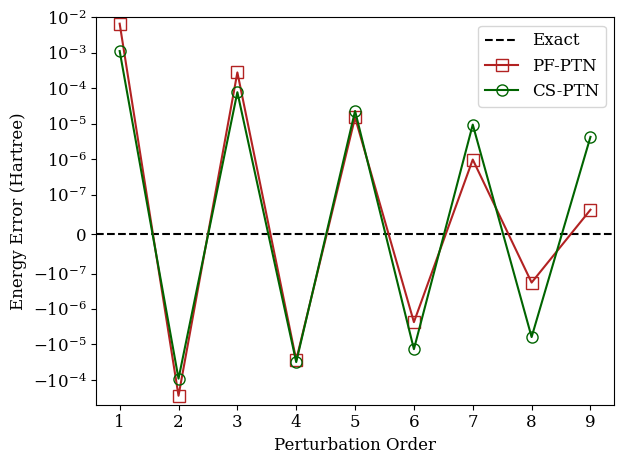

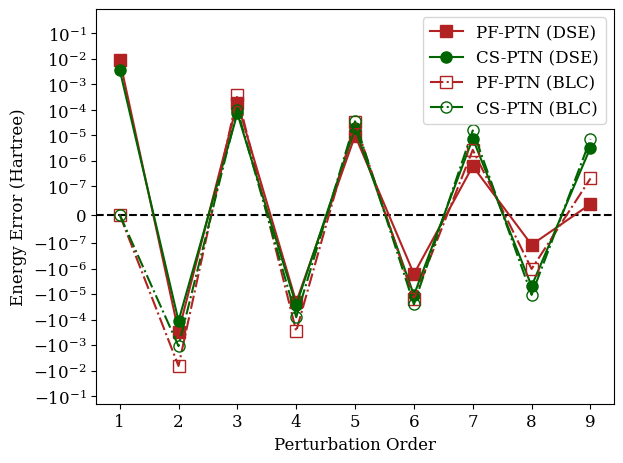

In [82]:
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

COLOUR1 = "firebrick"
COLOUR2 = "darkgreen"
COLOUR3 = "royalblue"
COLOUR4 = "rebeccapurple"
COLOUR5 = 'darkorchid'
COLOUR6 = 'olivedrab'

#fit_pfci = poly_eval(x_pfci, coef_pfci, 5)
#fit_pcqed = poly_eval(x_pcqed_pn, coef_pcqed, 5)

#plt.plot(x_pfci, y_pfci, color=COLOUR3, marker="o",  ms="8", label="PF-FCI-N/6-31G" )
#plt.plot(x_pcqed_pn, y_pcqed_pn, color=COLOUR1,marker="s",  ms="10", mfc="none", linestyle="dashed", label="pPF(50,N)/6-31G" )
#plt.plot(x_pcqed_pn, y_csfci, color=COLOUR2, linestyle="none", marker="^",  ms="8", label="CS-FCI-N/6-31G")
#plt.plot(x_pcqed_pn, y_pcqed_cs, color=COLOUR5, linestyle="none", marker="s",  ms="10", mfc="none", label="pCS(50,N)/6-31G")

plt.axhline(y = 0, color = "black", linestyle="dashed", label="Exact")
#plt.axhline(y = _cs_pcqed[0, 0], label = "CS", color = "blue")
plt.plot(Order, PN_PTN_ETotal, color = COLOUR1, linestyle="solid", marker="s",  ms="8", mfc="none", label="PF-PTN" )
plt.plot(Order, CS_PTN_ETotal, color = COLOUR2, linestyle="solid", marker="o", ms="8", mfc="none", label="CS-PTN")
plt.ylabel("Energy Error (Hartree)")
plt.xlabel("Perturbation Order")
plt.yscale('symlog', linthresh=1e-7)
plt.ylim(-5e-4, 1e-2)
plt.legend()
plt.tight_layout()
plt.savefig("PT9.png", dpi=250)
plt.show()


plt.axhline(y = 0, color = "black", linestyle="dashed")
#plt.axhline(y = _cs_pcqed[0, 0], label = "CS", color = "blue")
plt.plot(Order, pn_dse[1:], color = COLOUR1, linestyle="solid", marker="s",  ms="8", label="PF-PTN (DSE)" )
plt.plot(Order, cs_dse[1:], color = COLOUR2, linestyle="solid", marker="o", ms="8", label="CS-PTN (DSE)")
plt.plot(Order, pn_blc[1:], color = COLOUR1, linestyle="dashdot", marker="s",  ms="8", mfc="none", label="PF-PTN (BLC)" )
plt.plot(Order, cs_blc[1:], color = COLOUR2, linestyle="dashdot", marker="o", ms="8", mfc="none", label="CS-PTN (BLC)")
plt.ylabel("Energy Error (Hartree)")
plt.xlabel("Perturbation Order")
plt.yscale('symlog', linthresh=1e-7)
plt.ylim(-2e-1, 9e-1)
plt.legend()
plt.tight_layout()
plt.savefig("PTDSE.png", dpi=250)
plt.show()

#plt.ylim(-8.0097, -8.0096)

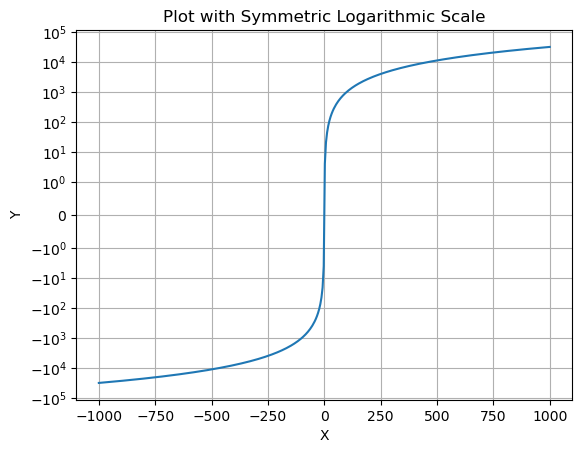

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data containing both positive and negative numbers
x = np.linspace(-1000, 1000, 400)
y = np.sign(x) * (np.abs(x) ** 1.5)

plt.plot(x, y)

# Set the y-axis to symmetric log scale
plt.yscale('symlog', linthresh=1)

# Add labels and show the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot with Symmetric Logarithmic Scale')
plt.grid(True)
plt.show()

In [ ]:


N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 100
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_50010 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_50010[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]

    print(np.sum(instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector, coherent_state=True, coherent_state_pos=0)))

    print(_pcqed_50010[ctr, 0])
    ctr += 1

In [ ]:


N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 200
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_20010 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_20010[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]

    #print(np.sum(instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector, coherent_state=True, coherent_state_pos=0)))

    print(_pcqed_20010[ctr, 0])
    ctr += 1

In [ ]:

orders = [0,1,2,3,4,5,6,7,8,9,10]

pt_cs = []
pt_pn = []

N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 200
N_ph = 3
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_100_3_pn = np.zeros((N_l, N_el * N_ph))
_pcqed_100_3_cs = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0

for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_100_3_pn[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]
    _pcqed_100_3_cs[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector, coherent_state=True,  coherent_state_pos=0)[0]

    for order in orders:
        pt_pn.append(np.sum(instance.compute_energy_corrections(order, N_el, N_ph, omega, lambda_vector)))
        pt_cs.append(np.sum(instance.compute_energy_corrections(order, N_el, N_ph, omega, lambda_vector, coherent_state=True, coherent_state_pos=0)))

    print(_pcqed_50010[ctr, 0])
    ctr += 1

In [ ]:
plt.axhline(y = _pcqed_100_3_pn[0, 0], label = "PN" , color = "green")
plt.axhline(y = _pcqed_100_3_cs[0, 0], label = "CS", color = "blue")

plt.plot(pt_pn, color = "green")
plt.plot(pt_cs, color = "blue")

plt.ylabel("energy (Hartree)")
plt.xlabel("pertrubation order")
plt.legend()


plt.ylim(-8.0097, -8.0096)

In [ ]:

plt.plot(np.abs(pt_pn - _pcqed_20010[0, 0]), color = "green")
plt.plot(np.abs(pt_cs- _pcqed_20010[0, 0]), color = "blue")

plt.ylabel("energy (Hartree)")
plt.xlabel("pertrubation order")
plt.legend()

plt.ylim(0,0.0001)


